In [1]:
! pip install picnik # Ejecutar esta celda no es ncesario si ya se instaló pICNIK

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import picnik as pnk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
#import seaborn as sns
plt.rcParams.update({'font.size': 14})

### The data used in this examples is a simulated process that follows an F1 reaction model: $f(\alpha)=1-\alpha$, with the Arrhenius parameters: $E=75$ kJ/mol and $\ln{(A/min)} = 12$

### The data represents four thermogravitric experiments of linear temperature programs with heating rates of $(2.5,5,10$ and $20)$ K/min

In [4]:
""" Data """
#The usual definition of the files with experimental data
one_step = ['E_cnt_2.5.csv',
            'E_cnt_5.csv',
            'E_cnt_10.csv',
            'E_cnt_15.csv',
            'E_cnt_20.csv']

### The extraction of the data is the same in every aspect but one, an additional variable must be defined in the `Isoconversion(` method, which is labeled as `da_DF` in this example (line four of the next cell). This variable is for a method in development so we won't use further, but it is necessary in this step.

Files to be used: 
['/home/erickerock/Materiales/Thermokinetics/Biomasa_Raul/SMW_5.csv', '/home/erickerock/Materiales/Thermokinetics/Biomasa_Raul/SMW_10.csv', '/home/erickerock/Materiales/Thermokinetics/Biomasa_Raul/SMW_15.csv', '/home/erickerock/Materiales/Thermokinetics/Biomasa_Raul/SMW_20.csv']
 
Reading files and creating DataFrames...

The computed heating rates are:


 5.000 +/- 0.002 K/min


 9.999 +/- 0.005 K/min


14.997 +/- 0.010 K/min


19.995 +/- 0.017 K/min



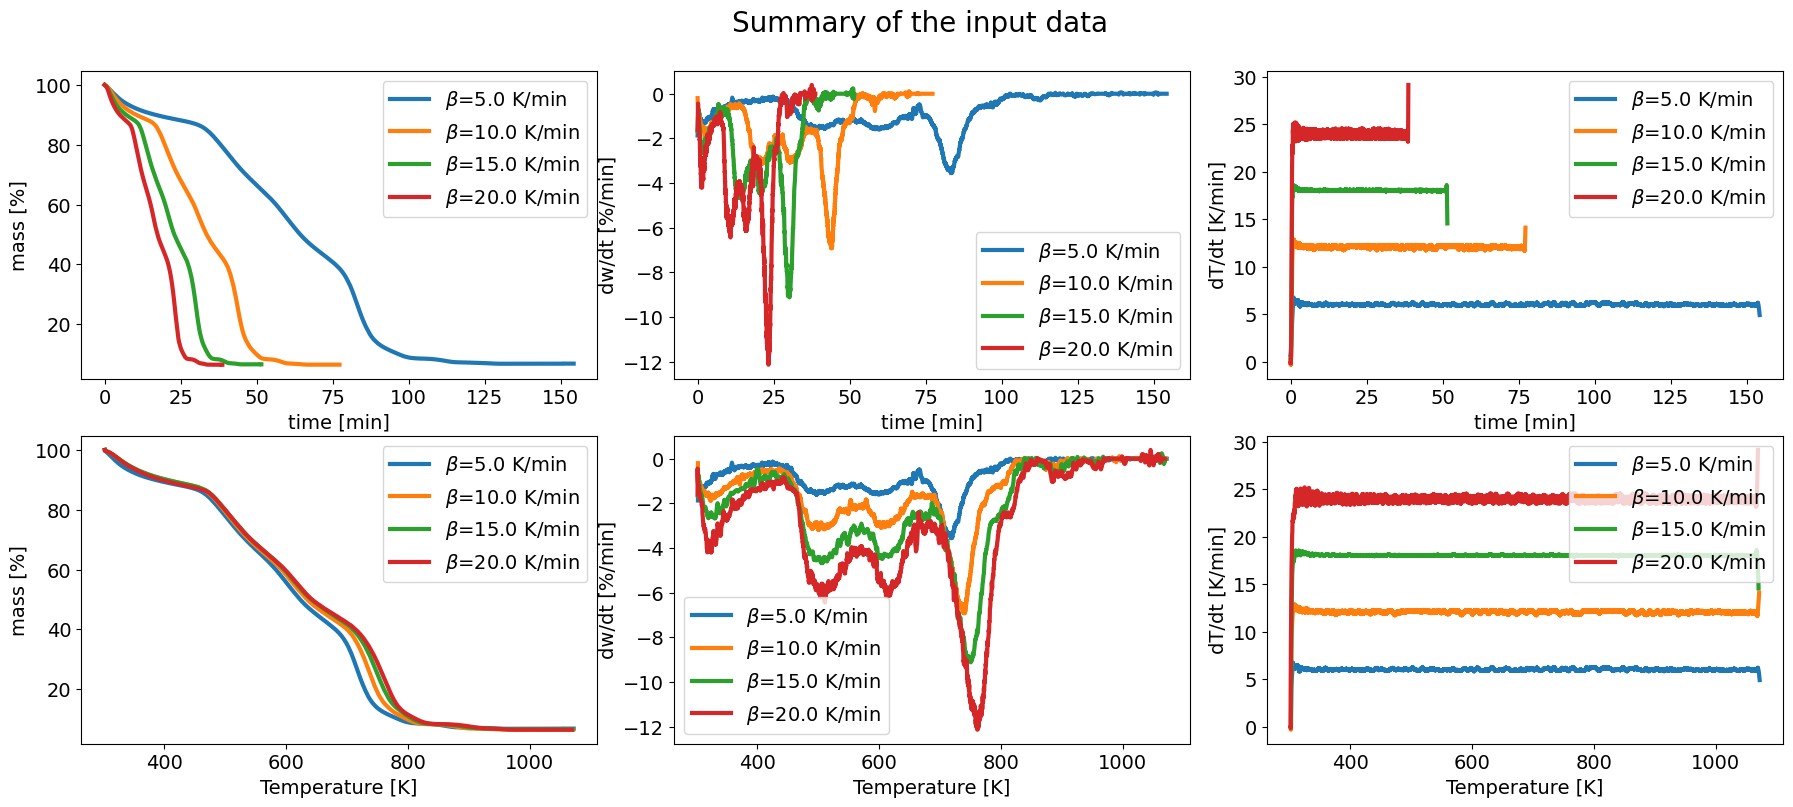

In [5]:
# The usual DataExtraction commands
xtr = pnk.DataExtraction()
B, T0 = xtr.read_files(one_step)

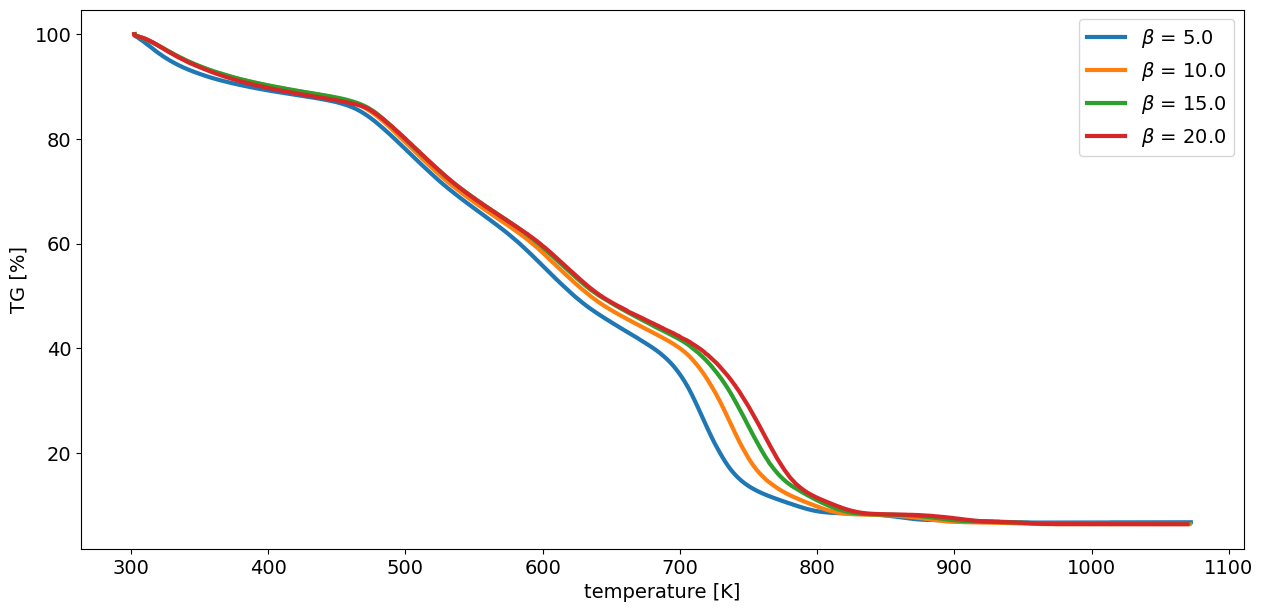

In [7]:
xtr.plot_data(x_data='temperature', x_units='K')

Computing conversion values...
Done


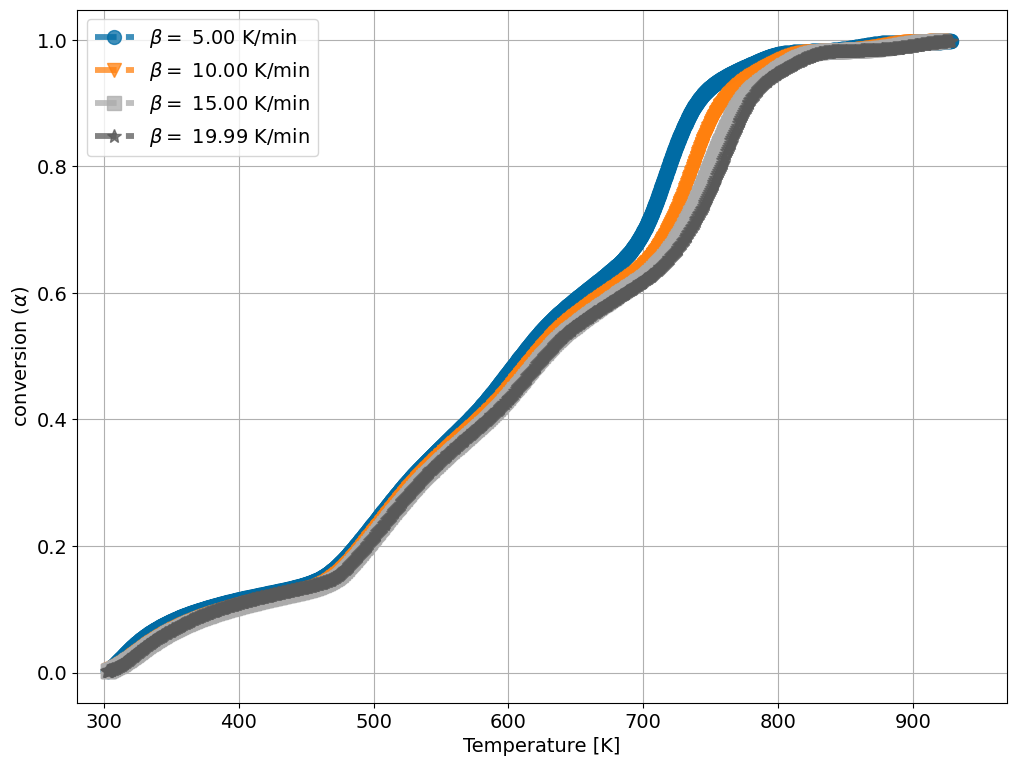

Creating Isoconversion DataFrames...
Done


In [12]:
xtr.Conversion(300*np.ones(len(B)),
               950*np.ones(len(B)))
isoTables  = xtr.Isoconversion(d_a = 0.005) #The last element in the left side

In [14]:
# The ActivationEnergy object is summoned as ususal
ace = pnk.ActivationEnergy(B,
                           T0,
                           isoTables)

## Activation Energy

## The "classic" methods, i.e., Fr(, OFW(, KAS( and Vy( remain the same. While the advanced method of Vyazovkin has suffered some minor modifications. One of them is the possiblity to define the parameter $p$, which defines the level of confidence for the error associated to the activation energy, being 1 a 100%. Other modifications include the integration method (available methods: trapezoid(default),simpson and romberg). The Romberg method may be a little more accurate but takes a lot more of time.  

In [15]:
aVy = ace.aVy((5,380),var='time', p= 0.90)

Advanced Vyazovkin method: Computing activation energies...
Done.


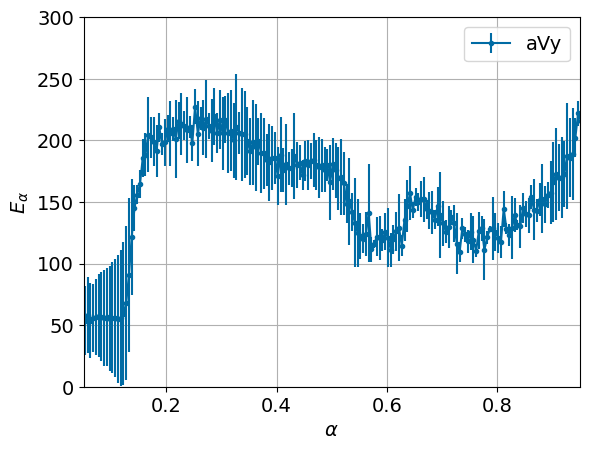

In [17]:
ace.Ea_plot()

## Pre-exponential factor

## The pre-exponential factor is computed by means of the so-called compensation effect, which implies a linear relation between the pre-exponential factor and the activation energy: $\ln{A}=a+bE$

## A linear regression is computed over a set of {$E_{i}$,$\ln{A_{i}}$} to obtain the parameters $a$ and $b$.
## The values of {$E_{i}$,$\ln{A_{i}}$} are obatined from fitting different models $f(\alpha)_{i}$ (defined in the picnik.rxn_models submodule) to the experimental data

## All this information is returned from the ActivationEnergy.compensation_effect method

In [20]:
compensation = ace.compensation_effect(0,
                                       aVy[2],
                                       aVy[3],
                                       error_m='r_Lin')

Accuracy not met with precision of $r^2$ = 0.9999. Lowering precision to $r^2$ = 0.999
Accuracy not met with precision of $r^2$ = 0.999. Lowering precision to $r^2$ = 0.99
Accuracy not met with precision of $r^2$ = 0.99. Lowering precision to $r^2$ = 0.95
Accuracy not met with precision of $r^2$ = 0.95. Lowering precision to $r^2$ = 0.85


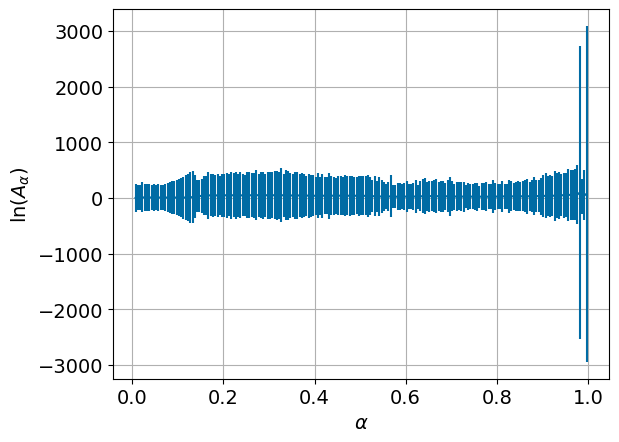

In [22]:
plt.errorbar(aVy[0],
             compensation[0],
             compensation[1])
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\ln(A_{\alpha})$')
plt.grid(True)

## Model reconstruction

## The numerical reconstruction of the reaction model is carried on in its integral form, $g(\alpha)$
## Given an array of activation energy, $E$, and an array of pre-exponential factor, the integral reaction model can be computed as:
## $g(\alpha) = \sum_{i} g(\alpha_{i}) = \sum_{i} A_{\alpha_{i}} \int_{t_{\alpha_{i-1}}}^{t_{\alpha_{i}}}\exp(-\frac{E_{\alpha_{i}}}{RT(t_{\alpha_{i}})})dt$

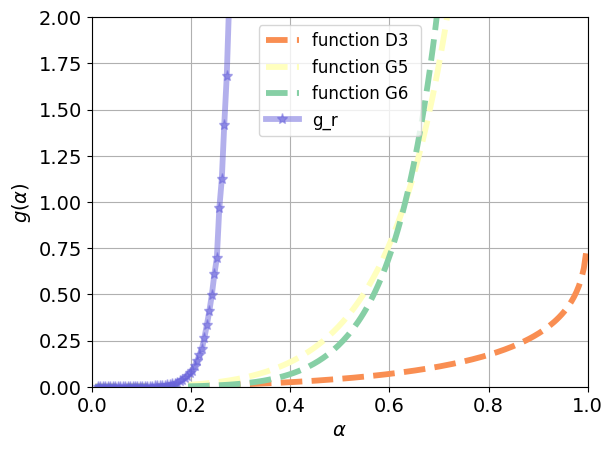

In [23]:
g_a = ace.reconstruction(aVy[2],
                         np.exp(compensation[0]),
                         B[0])

### The cell below plots different reaction models in the integral form, $g(\alpha)_{i}$. As we are using F1 generated data, our reconstructed data should be overlapping with the values of the F1 model.

### As noted by inspection of the plot of $\ln{A}$ vs $\alpha$, the value of $\ln{A}$ (~ 10.6) differs from the progammed one (12), giving thus an unreliable reconstruction, which is why g_r doesn reproduced the simulated data. If one uses the programmed value for $\ln{A}$ and the computed values with the `aVy(` method (g_r2) there is still a discrepancy between the computed data and the real model. Finally, by using the average of the activation energy array (g_r3) we recover the simulated model. The moral is, the `compensation_effect(` (as programmed in picnik) is unreliable and if you wish to recompute numerically $g(\alpha)$, you need to be sure that the process is single step and use the averge activation energy.

### Isothermal prediction

### For this example, the conversion as a function of time is given by: $\alpha(t) = 1-\exp{[-A\exp(-\frac{E}{RT})t]} $
### We compare the results of the computed predictions with three picnik methods, each based on a different equation:

### a) Model based prediction:          $t_{\alpha_{i}} = \frac{\sum_{i}g(\alpha_{i})}{A\exp{(-\frac{E}{RT_{0}})}}$   ...(1)
### b) Isoconversion prediction A:      $t_{\alpha_{i}} = \frac{\int_{t_{\alpha_{0}}}^{t_{\alpha_{i}}}\exp(-\frac{E}{RT(t)})}{\exp{(-\frac{E}{RT_{0}})}}$   ...(2)
### c) Isoconversion prediction B:      $J[E_{\alpha},T(t)]=J[E_{\alpha},T_{0}]$   ...(3)

### As it can be seen from the expressions above, the methods do not compute conversion as a funciton of time, but they compute the time required to reach a given conversion

### The next three cells have the following contents:
### The first one, defines conversion as a function of time according to the F1 model and creates tima and conversion arrays ti plot.
### The second one has the three tipes of prediction according to the equations above
### The third one is a plot of the predictions and the model

### It is clear that all three equations give accurate isothermal predictions. Althoug we recommend the one of equation (3) as it implies less assumptions about the process

In [24]:
def alpha_F1_iso(t,A,E,isoT):
    return 1- np.exp(-A*np.exp(-E/(0.0083144626*isoT))*t)

time = np.linspace(0,200,len(aVy[0]))                                    # Time arrays to comupute the theoretical conversion values
alp  = alpha_F1_iso(time,np.exp(12),75,575)                               # Theoretical conversion with E = 75 kJ/mol and ln(A/min)=12

In [30]:
tim_pred1 = ace.t_isothermal(aVy[2],compensation[0],575,col=0,g_a=g_a,alpha=aVy[0])       # Prediction with eq (1)
tim_pred2 = ace.t_isothermal(aVy[2],compensation[0],575,col=0,isoconv=True)              # Prediction with eq (2)
ap,Tp,tp  = ace.modelfree_prediction(aVy[2],B=0,isoT =575, alpha=0.999,bounds = (10,10))  # Prediction with eq (3)

Beginning simulation at :  0  min
simulation completed


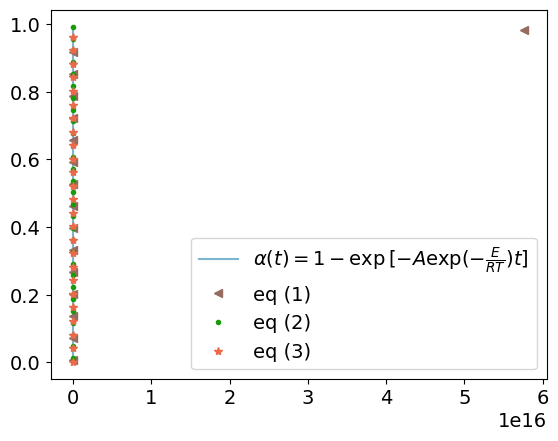

In [32]:
plt.plot(time,alp,alpha=0.5,label=r'$\alpha(t) = 1-\exp{[-A\exp(-\frac{E}{RT})t]}$')
plt.plot(tim_pred1[::13],aVy[0][::13],'<',c='#966B60',label='eq (1)')
plt.plot(tim_pred2[::7],aVy[0][1:-1:7],'.',c='#169C09',label='eq (2)')
plt.plot(tp[::8],ap[::8],'*',c='#EB6A49',label='eq (3)')

plt.legend()

## Non-isothermal predictioin

## In this section we ilustrate the use of the methods for non-isothermal predictions with linear, or an arbitrary temperature program

In [35]:
# This is a prediction of the conversion under a linear heating rate of 10 K/min
ap2,Tp2,tp2 = ace.modelfree_prediction(aVy[2],B=10,alpha=0.999, bounds = (10,10))

Beginning simulation at :  0  min
simulation completed


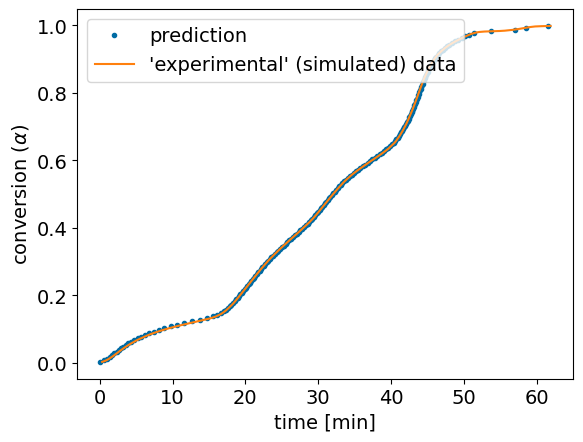

In [37]:
plt.plot(tp2,ap2,'.',label='prediction')
plt.plot(xtr.t[1],xtr.alpha[1],label="'experimental' (simulated) data")

plt.ylabel(r'conversion ($\alpha$)')
plt.xlabel('time [min]')
plt.legend(loc='upper left')

### Exporting results

In [41]:
""" Energía de activación """
ace.export_Ea()

Exporting data in csv format...
Done


In [45]:
""" Triplete cinético """
ace.export_kinetic_triplet(aVy[0][1::], aVy[2][1::], compensation[0][1::], g_a, name="kinetic_triplet.csv" )

In [ ]:
""" Predicción """
ace.export_prediction(ap2,Tp2,tp2)